#  과제2-1. 수어번역기 모델링 및 추적(개인과제)

## 1.환경준비

### (1) 라이브러리 로딩

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

from sklearn.model_selection import train_test_split

from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

import mlflow
import mlflow.keras

In [2]:
np.set_printoptions(linewidth=np.inf)

* 함수 만들기

In [3]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

#### 1) 데이터 가져오기
* 제공 받은 데이터를 여러분의 구글드라이브 적절한 위치에 업로드 합니다.
    * 가능하면, 구글드라이브 첫 경로 밑에 폴더를 만들고 업로드 하기를 권장합니다.

In [62]:
path = ''
file = 'sign_language.csv'

data = pd.read_csv(path+file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [63]:
data.shape

(8000, 785)

#### 2) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [67]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

### (3) mlflow 추적 준비

In [68]:
mlflow_uri = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(mlflow_uri)

### (4) 새 실험 생성
* exp4

In [ ]:
exp_id = mlflow.create_experiment("exp4")
exp_id

## 2 데이터 살펴보기

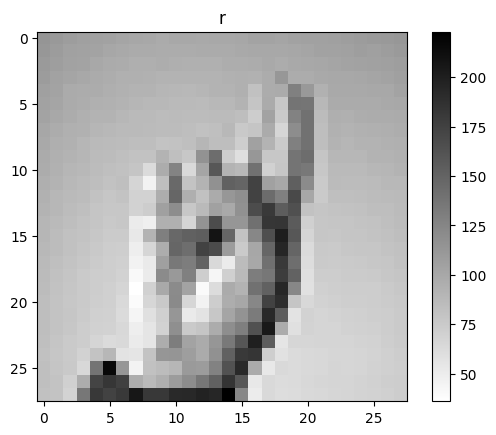

In [69]:
# 아래 숫자를 바꿔가며 화면에 그려 봅시다.
n = 100
sign_fig = data.iloc[n, 1:].values
sign_fig = sign_fig.reshape(28, 28)

sign = class_names[data.iloc[n,0]]

plt.title(sign)
plt.imshow(255-sign_fig, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

## 3.데이터 준비

* 주어진 데이터셋
    * 2차원 데이터셋, 1차원 데이터포인트(분석단위, 예측단위) 입니다. 
    * 흑백 이미지데이터
    * 이 데이터로부터 데이터 준비작업을 수행합니다.
        * 데이터 분할1 : x, y
        * 데이터 분할2 : train, validation
        * 만약 CNN으로 모델링을 한다면, shape를 맞춰야 합니다. (n, 28, 28, 1) 
        * scaling
* 그러나 운영에서 발생될 데이터는 이미지 한장 한장 입니다. 이미지 한장, 한장 들어온다면 어떻게 데이터가 처리되어야 할까요?(Data Pipeline 구성)

### (1) 데이터 분할1 : x, y 나누기

In [70]:
target = 'label'
x = data.drop(target, axis=1)
y = data.loc[:, target]

### (2) 데이터 분할2 : train, validation, test

* train : val : test = 5000 : 2000 : 1000
* 여기서 test set은 파이프라인 점검을 위한 용도로 사용합니다.

In [71]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1000, random_state=2023)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=2000, random_state=2023)

In [72]:
x_train.shape, x_val.shape, x_test.shape

((5000, 784), (2000, 784), (1000, 784))

### (3) DL을 위한 전처리
* 모두 넘파이로 변환

In [73]:
x_train, y_train = x_train.values, y_train.values
x_val, y_val = x_val.values, y_val.values

* shape 맞추기 n, 28,28,1
    * reshape
        * x_train.shape : (-1, 28, 28, 1)
        * x_val.shape : (-1, 28, 28, 1)
        * x_test.shape : (-1, 28, 28, 1)

In [74]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [75]:
x_train.shape, x_val.shape

((5000, 28, 28, 1), (2000, 28, 28, 1))

* Scaling : Min-Max
    * 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
    * x_train2, x_val2 를 그냥 255로 나누면 됨

In [76]:
x_train = x_train / 255
x_val = x_val / 255

x_train.max(), x_train.min(), x_val.max(), x_val.min()

(1.0, 0.0, 1.0, 0.0)

## 4.모델링

### (1) 모델1

In [32]:
with mlflow.start_run(experiment_id=3):
    
    # autolog 시작
    mlflow.keras.autolog()
    
    # 모델 설계 및 컴파일
    model = Sequential([Input(shape=(28, 28, 1)),
                        Flatten(),
                        Dense(512, activation='relu'),
                        Dense(26, activation='softmax') ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

    # 학습
    history = model.fit(x_train, y_train, epochs=30, validation_split=.02).history
    
    # 예측
    pred = model.predict(x_val)
    acc = accuracy_score(y_val, pred.argmax(axis=1))
    
    # accuracy
    mlflow.log_metric("accuracy", acc)
    
    # 모델등록
    mlflow.keras.log_model(model, "keras-model",  registered_model_name="DL2_1")
    
    # autolog 종료
    mlflow.keras.autolog(disable=True)

Epoch 1/30
154/154 [==============================] - 2s 10ms/step - loss: 2.7998 - val_loss: 2.1969
Epoch 2/30
154/154 [==============================] - 2s 10ms/step - loss: 2.0226 - val_loss: 1.7392
Epoch 3/30
154/154 [==============================] - 2s 11ms/step - loss: 1.6312 - val_loss: 1.4949
Epoch 4/30
154/154 [==============================] - 2s 10ms/step - loss: 1.3887 - val_loss: 1.3911
Epoch 5/30
154/154 [==============================] - 2s 11ms/step - loss: 1.2483 - val_loss: 1.2376
Epoch 6/30
154/154 [==============================] - 2s 10ms/step - loss: 1.1100 - val_loss: 1.2752
Epoch 7/30
154/154 [==============================] - 2s 12ms/step - loss: 1.0215 - val_loss: 1.0940
Epoch 8/30
154/154 [==============================] - 2s 11ms/step - loss: 0.9314 - val_loss: 0.9447
Epoch 9/30
154/154 [==============================] - 2s 10ms/step - loss: 0.8890 - val_loss: 1.0786
Epoch 10/30
154/154 [==============================] - 2s 11ms/step - loss: 0.7968 - val_lo

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp45uukf0p\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp45uukf0p\model\data\model\assets


63/63 [==============================] - 0s 2ms/step


2023/05/18 15:33:05 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmptzs63lfn\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmptzs63lfn\model\data\model\assets
Registered model 'DL2_1' already exists. Creating a new version of this model...
2023/05/18 15:33:15 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DL2_1, version 4
Created version '4' of model 'DL2_1'.


* 학습곡선

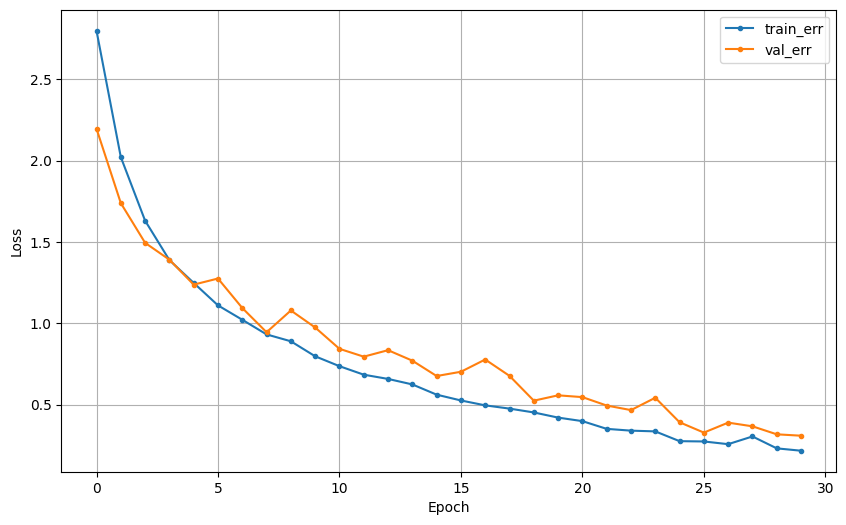

In [33]:
dl_history_plot(history)

* 예측 및 검증

In [ ]:
x_test = x_test.values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test / 255

In [ ]:
pred = model.predict(x_test).argmax(axis=1)

print(accuracy_score(y_test, pred))
print(classification_report(class_names[y_test], class_names[pred]))

### (2) 모델2

In [41]:
with mlflow.start_run(experiment_id=3):
    
    # autolog 시작
    mlflow.keras.autolog()
    
    # 모델 설계 및 컴파일
    model = Sequential([Input(shape=(28, 28, 1)),
                        Flatten(),
                        Dense(512, activation='relu'),
                        Dropout(0.25),
                        Dense(26, activation='softmax') ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

    # 학습
    history = model.fit(x_train, y_train, epochs=30, validation_split=.02).history
    
    # 예측
    pred = model.predict(x_val)
    acc = accuracy_score(y_val, pred.argmax(axis=1))
    
    # accuracy
    mlflow.log_metric("accuracy", acc)
    
    # 모델등록
    mlflow.keras.log_model(model, "keras-model",  registered_model_name="DL2_1")
    
    # autolog 종료
    mlflow.keras.autolog(disable=True)

Epoch 1/30
154/154 [==============================] - 2s 12ms/step - loss: 2.9679 - val_loss: 2.5150
Epoch 2/30
154/154 [==============================] - 2s 13ms/step - loss: 2.3514 - val_loss: 1.9503
Epoch 3/30
154/154 [==============================] - 2s 12ms/step - loss: 1.9878 - val_loss: 1.6607
Epoch 4/30
154/154 [==============================] - 2s 14ms/step - loss: 1.7572 - val_loss: 1.6197
Epoch 5/30
154/154 [==============================] - 2s 13ms/step - loss: 1.6099 - val_loss: 1.3884
Epoch 6/30
154/154 [==============================] - 2s 14ms/step - loss: 1.4769 - val_loss: 1.3436
Epoch 7/30
154/154 [==============================] - 2s 14ms/step - loss: 1.3984 - val_loss: 1.1769
Epoch 8/30
154/154 [==============================] - 2s 13ms/step - loss: 1.2919 - val_loss: 1.1187
Epoch 9/30
154/154 [==============================] - 2s 12ms/step - loss: 1.2379 - val_loss: 1.1387
Epoch 10/30
154/154 [==============================] - 2s 13ms/step - loss: 1.1651 - val_lo

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpr9s1fpcn\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpr9s1fpcn\model\data\model\assets


63/63 [==============================] - 0s 2ms/step


2023/05/18 15:37:47 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp43eirm4q\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp43eirm4q\model\data\model\assets
Registered model 'DL2_1' already exists. Creating a new version of this model...
2023/05/18 15:37:57 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DL2_1, version 5
Created version '5' of model 'DL2_1'.


* 학습곡선

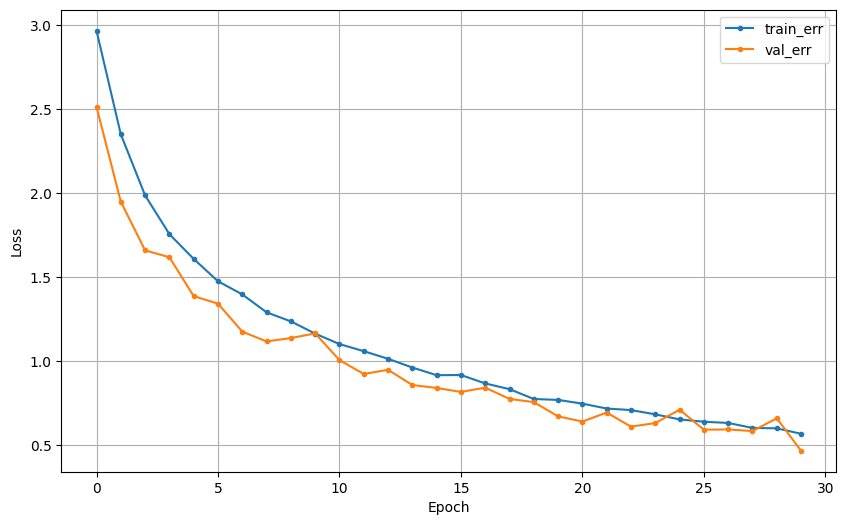

In [42]:
dl_history_plot(history)

* 예측 및 검증

In [ ]:
pred = model.predict(x_test).argmax(axis=1)

print(accuracy_score(y_test, pred))
print(classification_report(class_names[y_test], class_names[pred]))

### (3) 모델3

In [ ]:
with mlflow.start_run(experiment_id=3):
    
    # autolog 시작
    mlflow.keras.autolog()
    
    # 모델 설계 및 컴파일
    model = Sequential([Input(shape=(28, 28, 1)),
                        Conv2D(filters=256, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu'),
                        Flatten(),
                        Dense(512, activation='relu'),
                        Dense(26, activation='softmax') ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

    # 학습
    history = model.fit(x_train, y_train, epochs=30, validation_split=.02).history
    
    # 예측
    pred = model.predict(x_val)
    acc = accuracy_score(y_val, pred.argmax(axis=1))
    
    # accuracy
    mlflow.log_metric("accuracy", acc)
    
    # 모델등록
    mlflow.keras.log_model(model, "keras-model",  registered_model_name="DL2_1")
    
    # autolog 종료
    mlflow.keras.autolog(disable=True)

* 학습곡선

In [ ]:
dl_history_plot(history)

In [ ]:
pred = model.predict(x_test).argmax(axis=1)

print(accuracy_score(y_test, pred))
print(classification_report(class_names[y_test], class_names[pred]))

### (4) 모델4

In [44]:
with mlflow.start_run(experiment_id=3):
    
    # autolog 시작
    mlflow.keras.autolog()
    
    # 모델 설계 및 컴파일
    model = Sequential([Input(shape=(28, 28, 1)),
                        Flatten(),
                        Dense(512, activation='relu'),
                        Dense(256, activation='relu'),
                        Dense(26, activation='softmax') ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

    # 학습
    history = model.fit(x_train, y_train, epochs=30, validation_split=.02).history
    
    # 예측
    pred = model.predict(x_val)
    acc = accuracy_score(y_val, pred.argmax(axis=1))
    
    # accuracy
    mlflow.log_metric("accuracy", acc)
    
    # 모델등록
    mlflow.keras.log_model(model, "keras-model",  registered_model_name="DL2_1")
    
    # autolog 종료
    mlflow.keras.autolog(disable=True)

Epoch 1/30
154/154 [==============================] - 4s 20ms/step - loss: 2.8384 - val_loss: 2.1815
Epoch 2/30
154/154 [==============================] - 2s 15ms/step - loss: 1.9243 - val_loss: 1.6127
Epoch 3/30
154/154 [==============================] - 3s 16ms/step - loss: 1.4896 - val_loss: 1.4822
Epoch 4/30
154/154 [==============================] - 2s 14ms/step - loss: 1.2478 - val_loss: 1.3983
Epoch 5/30
154/154 [==============================] - 2s 16ms/step - loss: 1.0783 - val_loss: 1.0470
Epoch 6/30
154/154 [==============================] - 2s 15ms/step - loss: 0.9604 - val_loss: 0.9858
Epoch 7/30
154/154 [==============================] - 2s 14ms/step - loss: 0.8631 - val_loss: 0.9111
Epoch 8/30
154/154 [==============================] - 2s 15ms/step - loss: 0.7693 - val_loss: 0.8884
Epoch 9/30
154/154 [==============================] - 2s 15ms/step - loss: 0.6808 - val_loss: 0.7579
Epoch 10/30
154/154 [==============================] - 2s 15ms/step - loss: 0.5512 - val_lo

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmppa5ie72r\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmppa5ie72r\model\data\model\assets


63/63 [==============================] - 0s 3ms/step


2023/05/18 15:43:24 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpya8hzpeu\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpya8hzpeu\model\data\model\assets
Registered model 'DL2_1' already exists. Creating a new version of this model...
2023/05/18 15:43:32 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DL2_1, version 6
Created version '6' of model 'DL2_1'.


* 학습곡선

In [ ]:
dl_history_plot(history)

In [ ]:
pred = model.predict(x_test).argmax(axis=1)

print(accuracy_score(y_test, pred))
print(classification_report(class_names[y_test], class_names[pred]))

In [45]:
with mlflow.start_run(experiment_id=3):
    
    # autolog 시작
    mlflow.keras.autolog()
    
    # 모델 설계 및 컴파일
    model = Sequential([Input(shape=(28, 28, 1)),
                        Flatten(),
                        Dense(256, activation='relu'),
                        Dense(128, activation='relu'),
                        Dense(128, activation='relu'),
                        Dense(26, activation='softmax') ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

    # 학습
    history = model.fit(x_train, y_train, epochs=30, validation_split=.02).history
    
    # 예측
    pred = model.predict(x_val)
    acc = accuracy_score(y_val, pred.argmax(axis=1))
    
    # accuracy
    mlflow.log_metric("accuracy", acc)
    
    # 모델등록
    mlflow.keras.log_model(model, "keras-model",  registered_model_name="DL2_1")
    
    # autolog 종료
    mlflow.keras.autolog(disable=True)

Epoch 1/30
  1/154 [..............................] - ETA: 1:23 - loss: 3.2956WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0026s vs `on_train_batch_end` time: 0.0039s). Check your callbacks.


154/154 [==============================] - 1s 4ms/step - loss: 2.9666 - val_loss: 2.4342
Epoch 2/30
154/154 [==============================] - 1s 3ms/step - loss: 2.0724 - val_loss: 1.8604
Epoch 3/30
154/154 [==============================] - 0s 3ms/step - loss: 1.5786 - val_loss: 1.5068
Epoch 4/30
154/154 [==============================] - 1s 3ms/step - loss: 1.3278 - val_loss: 1.2819
Epoch 5/30
154/154 [==============================] - 1s 4ms/step - loss: 1.1445 - val_loss: 1.2034
Epoch 6/30
154/154 [==============================] - 1s 4ms/step - loss: 1.0136 - val_loss: 1.0299
Epoch 7/30
154/154 [==============================] - 1s 3ms/step - loss: 0.8587 - val_loss: 1.0820
Epoch 8/30
154/154 [==============================] - 1s 4ms/step - loss: 0.7609 - val_loss: 0.8220
Epoch 9/30
154/154 [==============================] - 1s 3ms/step - loss: 0.6672 - val_loss: 0.8697
Epoch 10/30
154/154 [==============================] - 1s 4ms/step - loss: 0.6250 - val_loss: 0.7940
Epoch 11/3

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp7bthn85n\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp7bthn85n\model\data\model\assets


63/63 [==============================] - 0s 2ms/step


2023/05/18 15:44:34 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpp4n3i67t\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpp4n3i67t\model\data\model\assets
Registered model 'DL2_1' already exists. Creating a new version of this model...
2023/05/18 15:44:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DL2_1, version 7
Created version '7' of model 'DL2_1'.


In [46]:
with mlflow.start_run(experiment_id=3):
    
    # autolog 시작
    mlflow.keras.autolog()
    
    # 모델 설계 및 컴파일
    model = Sequential([Input(shape=(28, 28, 1)),
                        Flatten(),
                        Dense(512, activation='relu'),
                        Dense(512, activation='relu'),
                        Dense(256, activation='relu'),
                        Dense(26, activation='softmax') ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

    # 학습
    history = model.fit(x_train, y_train, epochs=30, validation_split=.02).history
    
    # 예측
    pred = model.predict(x_val)
    acc = accuracy_score(y_val, pred.argmax(axis=1))
    
    # accuracy
    mlflow.log_metric("accuracy", acc)
    
    # 모델등록
    mlflow.keras.log_model(model, "keras-model",  registered_model_name="DL2_1")
    
    # autolog 종료
    mlflow.keras.autolog(disable=True)

Epoch 1/30
154/154 [==============================] - 3s 17ms/step - loss: 2.7764 - val_loss: 2.1034
Epoch 2/30
154/154 [==============================] - 3s 18ms/step - loss: 1.8351 - val_loss: 1.7294
Epoch 3/30
154/154 [==============================] - 3s 18ms/step - loss: 1.4708 - val_loss: 1.4538
Epoch 4/30
154/154 [==============================] - 3s 19ms/step - loss: 1.1699 - val_loss: 1.4707
Epoch 5/30
154/154 [==============================] - 3s 18ms/step - loss: 1.1411 - val_loss: 1.5859
Epoch 6/30
154/154 [==============================] - 3s 20ms/step - loss: 0.8726 - val_loss: 0.9265
Epoch 7/30
154/154 [==============================] - 3s 20ms/step - loss: 0.7182 - val_loss: 1.1711
Epoch 8/30
154/154 [==============================] - 3s 22ms/step - loss: 0.6656 - val_loss: 0.9076
Epoch 9/30
154/154 [==============================] - 3s 22ms/step - loss: 0.5455 - val_loss: 0.8390
Epoch 10/30
154/154 [==============================] - 3s 22ms/step - loss: 0.5139 - val_lo

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpwrl9u31b\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpwrl9u31b\model\data\model\assets


63/63 [==============================] - 0s 4ms/step


2023/05/18 15:46:52 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpz94ruwb7\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpz94ruwb7\model\data\model\assets
Registered model 'DL2_1' already exists. Creating a new version of this model...
2023/05/18 15:47:02 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DL2_1, version 8
Created version '8' of model 'DL2_1'.


## 5.모델 사용하기
* 가장 성능이 좋은 모델 production 지정
* Production 모델 호출해서 test 셋으로 예측 및 평가



In [77]:
# 운영중인 버전 가져오기
model_uri = "models:/DL2_1/production" 
model_pro = mlflow.keras.load_model(model_uri)

In [79]:
x_test_v = x_test.values
x_test_rs = x_test_v.reshape(-1, 28, 28, 1)

In [80]:
pred_pro = model_pro.predict(x_test_rs)

32/32 [==============================] - 0s 4ms/step


In [81]:
pred_pro

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [85]:
pred_pro = pred_pro.argmax(axis=1)

In [86]:
print(accuracy_score(y_test, pred_pro))
print(classification_report(class_names[y_test], class_names[pred_pro]))

0.967
              precision    recall  f1-score   support

           a       1.00      0.98      0.99        44
           b       0.97      1.00      0.99        39
           c       1.00      1.00      1.00        28
           d       0.98      1.00      0.99        51
           e       0.93      0.97      0.95        39
           f       1.00      1.00      1.00        41
           g       1.00      1.00      1.00        41
           h       1.00      1.00      1.00        44
           i       0.95      0.93      0.94        44
           k       1.00      0.88      0.93        57
           l       1.00      1.00      1.00        41
           m       0.97      0.88      0.93        43
           n       0.93      1.00      0.96        39
           o       1.00      1.00      1.00        32
           p       1.00      0.97      0.98        31
           q       1.00      0.96      0.98        57
           r       0.92      1.00      0.96        44
           s       0.